# Dipy Simulation of HARDI signals

In this tutoral, synthetic HARDI signals are generated to demonstrate the orientation distribution functions (ODFs) estimated from different high angular resolution diffusion imaging (HARDI) signals.

### 1) Diffusion Spectrum Imaging

Below we show how one can calculate an ODF from diffusion spectrum imaging (DSI) for a voxel containing crossing fibres. For this we need to consider a full DSI acquisition containing a large number of q-vectors. A sample DSI acquisition can be loaded from "dipy.data"

In [1]:
import numpy as np

from dipy.data import get_fnames

btable = np.loadtxt(get_fnames('dsi515btable'))

The numpy matrix contains the b-values in the first column and the b-vectors in the last three columns. Let's create the GradientTable object for these parameters.

In [2]:
from dipy.core.gradients import gradient_table

gtab_dsi = gradient_table(btable[:, 0], btable[:, 1:])

Let's plot the q-vector grid. Since I don't know the diffusion time of this experiment, the q-vector grid is plotted in terms of vectors $q\sqrt{(\Delta)}$**n** which can be computed as $\sqrt{(b)}$**n**.

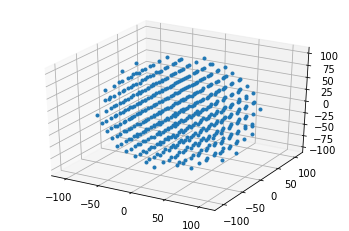

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

qvecs = gtab_dsi.bvecs.copy()

# making sure that vectors are unit vectors
for ind in range(0, 3):
    qvecs[:, ind] *= np.sqrt(gtab_dsi.bvals.copy())

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(qvecs[:, 0], qvecs[:, 1], qvecs[:, 2], '.')

Note that this GradientTable includes high b-values that are not typically accessible in current clinical scanners

In [4]:
print("The maximum b-value of this experiment is {}".format(np.max(gtab_dsi.bvals)))

The maximum b-value of this experiment is 11538.5


Now that we have the diffusion acquisition parameters defined, lets generate the synthetic signals for voxels containing two tensors with different orientations (crossing at 60𝑜60o). Note that this system corresponds to the multi tensor simulations performed in "Simulated_DTI_issue1" tutorial.

In [5]:
from dipy.sims.voxel import multi_tensor, _check_directions, all_tensor_evecs

AD_gt = 1.7e-3
RD_gt = 0.3e-3

# diffusion tensor main direction
angle1 = (60.0, 0.0)
angle2 = (0.0, 0.0)

# Reconstruct the eigenvalues of the diffusion tensor
evals1 = [AD_gt, RD_gt, RD_gt];
evals2 = [AD_gt, RD_gt, RD_gt];

# Produce DSI signals
mevals = np.array([evals1, evals2])
angles = [angle1, angle2]
S0 = 1
fractions = [50, 50]
signal_dsi, _ = multi_tensor(gtab_dsi, mevals, S0, angles, fractions, snr=None)

As for any other reconstruction model, DSI fitted is performed in two steps:

1) The DSI model must to be defined according to the given GradientTable object. As the DSI reconstruction model, the DSI model is available from "dipy.reconst"

In [6]:
from dipy.reconst.dsi import DiffusionSpectrumModel

dsi_model = DiffusionSpectrumModel(gtab_dsi)

2) Having the DSI model defined according to the acquisition parameters, synthetic signals can be fitted using the "fit" function in "dsi_model" class object.

In [7]:
dsi_fit = dsi_model.fit(signal_dsi)

The fit object will contain the different fitted parameters of the DSI model. For example, DSI's orientation distribution function (ODF) can be sampled from a given set of directions using the "dti_fit" attribute "odf".

In [8]:
from dipy.data import get_sphere
sphere = get_sphere('repulsion724').subdivide(1)

dsi_odf = dsi_fit.odf(sphere)

Now let's plot the sampled DSI-ODF.

In [9]:
from dipy.viz import window, actor

# transform our data from 1D to 4D
odf4D = dsi_odf[None, None, None, :]

scene = window.Scene()
odf_actor = actor.odf_slicer(odf4D, sphere=sphere, colormap='plasma')
odf_actor.display(y=0)
odf_actor.RotateX(90)
scene.add(odf_actor)

window.show(scene)

window.record(scene, n_frames=1, out_path='dsi_odf_multi_tensor.png', size=(600, 600))

C:\Users\rafae\anaconda3\envs\dipy_release\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


One can note that the DSI-ODF presents two peaks corresponding to the directions of the two tensors of the simulated system

### 2) Q-ball Constant Solid Angle Q-ball Imaging

Below we show how one can calculate an ODF from Q-ball constant solid angle (CSA) model for the same voxels containing crossing fibres. For this we need to consider an acquisition of one single non-zero b-value. We use the dipy tools introduced in "Simulated_DTI_issue1" to generate the dMRI acquisition parameters.

In [10]:
from dipy.core.sphere import disperse_charges, HemiSphere
from dipy.core.gradients import gradient_table

n_pts = 60
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)

hsph_updated, potential = disperse_charges(hsph_initial, 5000)

bvecs = np.vstack((np.array([0, 0, 0]), hsph_updated.vertices))
bvals = np.ones(n_pts + 1) * 2000
bvals[0] = 0;

gtab = gradient_table(bvals, bvecs)

Note that we use a higher b-value than used for DTI, since higher b-values provides higher directional angular resolution.

Below we generate the signals for the new acquisition protocol:

In [11]:
signal_hardi, _ = multi_tensor(gtab, mevals, S0, angles, fractions, snr=None)

Now that we have the dMRI acquisition parameters and signals simulated we can define the CSA model and perform the ODF reconstruction.

In [12]:
from dipy.reconst.shm import CsaOdfModel

csa_model = CsaOdfModel(gtab, 6)

csa_fit = csa_model.fit(signal_hardi)

csa_odf = csa_fit.odf(sphere)

Let's plot the CSA-ODF:

In [13]:
# transform our data from 1D to 4D
odf4D = csa_odf[None, None, None, :]

scene = window.Scene()
odf_actor = actor.odf_slicer(odf4D, sphere=sphere, colormap='plasma')
odf_actor.display(y=0)
odf_actor.RotateX(90)
scene.add(odf_actor)

window.show(scene)

window.record(scene, n_frames=1, out_path='csa_odf_multi_tensor.png', size=(600, 600))

Note that the csa_fit object also contains useful odf estimates such as the generalized fractional anisotropy (GFA) - a measurement that quantifies the anisotropy of ODFs. Lets print the GFA value for the CSA-ODF.

In [14]:
print("The CSA odf reconstructed has an GFA of {}".format(csa_fit.gfa))

The CSA odf reconstructed has an GFA of 0.4724452641015093


### 3) Constrained Spherical Deconvolution

Below we show how one can calculate a fibre ODF (fODF) using the constraint spherical deconvolution (CSD) for the signals generated below. For CSD we need to input the fibre response function, i.e. the expected diffusivities for a single fibre population. Since in simulations we know that the diffusivity of a single fibre population has an axial diffusivity of 1.7e-3 $mm^2/ms$ and radial diffusivity of 0.3e-3 $mm^2/ms$, lets manually define the response function as:

In [15]:
response = ([AD_gt, RD_gt, RD_gt], S0)

In Dipy, the response function for CSD is assumed to be a tuple of two elements. The first element containing the eigenvalues of the diffusivities of the single fibre population, while the second element containing the S0.

Now that we have the response function, we define the CSD model and fit the signals below:

In [16]:
from dipy.reconst.csdeconv import ConstrainedSphericalDeconvModel

csd_model = ConstrainedSphericalDeconvModel(gtab, response)

csd_fit = csd_model.fit(signal_hardi)

csd_odf = csd_fit.odf(sphere)

Let's plot the CSD-fODF:

In [17]:
# transform our data from 1D to 4D
odf4D = csd_odf[None, None, None, :]

scene = window.Scene()
odf_actor = actor.odf_slicer(odf4D, sphere=sphere, colormap='plasma')
odf_actor.display(y=0)
odf_actor.RotateX(90)
scene.add(odf_actor)

window.show(scene)

window.record(scene, n_frames=1, out_path='csd_fodf_multi_tensor.png', size=(600, 600))

### Deconvoluted DSI

Alternatively to the CSD fODF, several methods have been proposed to convert ODF to fODF. This includes the methods proposed by Canales et al. Neuroimage 2010, in which an fODF is computed from deconvoluting DSI's ODF. In Dipy, deconvoluted DSI can be imported from "dipy.reconst.dsi" as DiffusionSpectrumDeconvModel. Below let's reconstruct the sharped DSI-ODF.

In [18]:
from dipy.reconst.dsi import DiffusionSpectrumDeconvModel

dsid_model = DiffusionSpectrumDeconvModel(gtab_dsi)

dsid_fit = dsid_model.fit(signal_dsi)

dsid_odf = dsid_fit.odf(sphere)

odf4D = dsid_odf[None, None, None, :]

scene = window.Scene()
odf_actor = actor.odf_slicer(odf4D, sphere=sphere, colormap='plasma')
odf_actor.display(y=0)
odf_actor.RotateX(90)
scene.add(odf_actor)

window.show(scene)

window.record(scene, n_frames=1, out_path='dsi_fodf_multi_tensor.png', size=(600, 600))

### Supplementary information:

Note that signals of this tutorial are generated in the absence of noise. Synthetic noise can be added by defining an snr value on the "mulit_tensor" signal generator. Below we plot and CSA-ODF reconstructed from signals with added noise with SNR of 20.

In [19]:
signal_hardi, _ = multi_tensor(gtab, mevals, S0, angles, fractions, snr=20)

csa_fit = csa_model.fit(signal_hardi)
csa_odf = csa_fit.odf(sphere)

odf4D = csa_odf[None, None, None, :]

scene = window.Scene()
odf_actor = actor.odf_slicer(odf4D, sphere=sphere, colormap='plasma')
odf_actor.display(y=0)
odf_actor.RotateX(90)
scene.add(odf_actor)

window.show(scene)

window.record(scene, n_frames=1, out_path='csd_fodf_multi_tensor.png', size=(600, 600))